# **Twitter: Named Entity Recognition (NER) in Natural Language Processing**

**From Twitter’s perspective:**

- Twitter is inundated with a vast amount of textual data, with users generating
 around 500 million tweets per day.
- To enhance the understanding of trends and topics on the platform, Twitter aims to implement Named Entity Recognition (NER) for automatic content tagging and analysis.
- This initiative is intended to overcome the limitations of relying on user-generated hashtags, which can be inconsistent, inaccurate, or absent.
- By accurately identifying named entities in tweets, such as person names,
 locations, organizations, and others, Twitter can gain deeper insights into user conversations and trends

**Dataset Explanation: Twitter Named Entity Recognition (NER) Data**

The dataset for this NER project is designed to address the challenge of automatically identifying and categorizing key elements in tweets, bypassing the limitations of user-generated hashtags. It is specifically annotated for NER tasks, with a focus on Twitter data.

Dataset Characteristics:

- The dataset is annotated with 10 fine-grained NER categories: person,
geo-location, company, facility, product, music artist, movie, sports team, TV
show, and other.
- It was extracted from tweets and is presented in the CoNLL format, a popular
format for NLP tasks, particularly in English.
- The CoNLL format organizes the data with one word per line and sentences
separated by an empty line. Each line has a word and its corresponding NER
tag, categorizing the word into one of the specified entities.
- The prefixes 'B-' (Beginning) and 'I-' (Inside) are used to indicate the position of a word within an entity. 'B-' marks the beginning of an entity, and 'I-' is used for subsequent words within the same entity.

Example of ***CoNLL*** Format:
1. Harry: **B-PER**
2. Potter: **I-PER**
3. was: **O**
4. a: **O**
5. student: **O**
6. Living: **O**
7. in: **O**
8. London: **B-geo-loc**



**Problem Statement**

Assuming you're a data scientist at Twitter, your responsibility involves developing models to automatically identify and categorize named entities in tweets.

Your primary goals are:
- To train models that can accurately perform Named Entity Recognition (NER) on
 tweet data.
- To handle a variety of entities such as person names, locations, companies, and more, improving the accuracy of trend and topic analysis on the platform.
- To evaluate the models' performance and refine them for optimal accuracy and
 efficiency in real-time tweet analysis.

# **What does 'good' look like?**

## **1. Define the Problem Statement and perform Exploratory Data Analysis**

a. Definition of problem
- Understand the need for extracting named entities from tweets and how it enhances content analysis beyond hashtags.
- Identify the types of entities (like person, location, organization) that are most relevant to Twitter's data.
- Hint: Clearly state the objective of using NER in the context of Twitter.

b. Exploratory Data Analysis (EDA)

- Analyze the CoNLL-formatted data to understand how tweets are annotated with named entities.
- Use statistical and visualization tools to explore the frequency and distribution of different entity types within the tweets.
- Examine any patterns or inconsistencies in entity annotations, such as common misclassifications or ambiguous entities.
- Hint: Investigate the structure and characteristics of the dataset.

c. Scope for Exploration

- Explore the relationship between the tweet's content and its entities to gauge context sensitivity.
- Consider visualizing the distribution of entities to get a clearer picture of the data you’re working with.
- Hint: Visualize the data in various forms (histograms, bar charts, scatter plots) to get a comprehensive view of the distribution and relationships.


In [ ]:
# Installing required libraries

%pip install datasets transformers
%pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
# Importing required Libraries
import pandas as pd
import tensorflow as tf

In [ ]:
# Loading Data
def load_data(filename: str):
  # Conll file is stored as (token, tag) pairs, one per line
  # Extracting data from conll files
  with open(filename, 'r') as file:
    lines = [line[:-1].split() for line in file] # Skipping last line as it will be a blank space
  samples, start = [], 0
  for end, parts in enumerate(lines):
      if not parts:
          sample = [(token, tag)
                      for token, tag in lines[start:end]]
          samples.append(sample)
          start = end + 1
  if start < end:
    samples.append(lines[start:end])
  return samples

train_samples = load_data('wnut 16.txt.conll')
test_samples = load_data('wnut 16test.txt.conll')
samples = train_samples + test_samples
schema = ['_'] + sorted({tag for sentence in samples
                             for _, tag in sentence}) # '_' is used to indicate a null (blank) token.

In [ ]:
# Data Sample
train_samples[1]

[('Made', 'O'),
 ('it', 'O'),
 ('back', 'O'),
 ('home', 'O'),
 ('to', 'O'),
 ('GA', 'B-geo-loc'),
 ('.', 'O'),
 ('It', 'O'),
 ('sucks', 'O'),
 ('not', 'O'),
 ('to', 'O'),
 ('be', 'O'),
 ('at', 'O'),
 ('Disney', 'B-facility'),
 ('world', 'I-facility'),
 (',', 'O'),
 ('but', 'O'),
 ('its', 'O'),
 ('good', 'O'),
 ('to', 'O'),
 ('be', 'O'),
 ('home', 'O'),
 ('.', 'O'),
 ('Time', 'O'),
 ('to', 'O'),
 ('start', 'O'),
 ('planning', 'O'),
 ('the', 'O'),
 ('next', 'O'),
 ('Disney', 'B-facility'),
 ('World', 'I-facility'),
 ('trip', 'O'),
 ('.', 'O')]

**Exploratory Data Analysis (EDA)**

<Axes: xlabel='keys'>

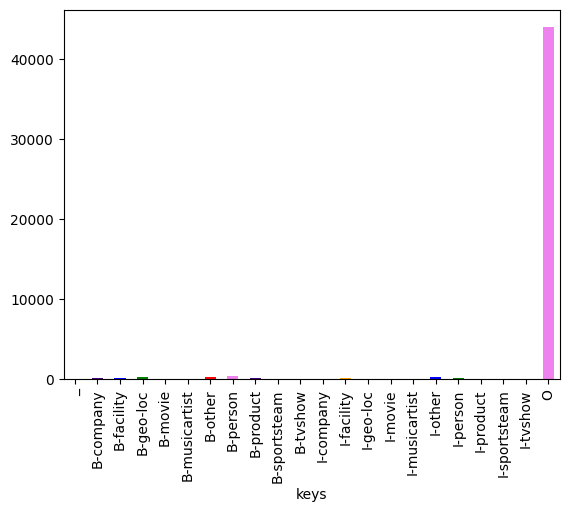

In [ ]:
import seaborn as sns
colors = ['violet', 'indigo', 'blue', 'green', 'yellow', 'orange', 'red']
counts = {}

for tag in schema:
  counts[tag] = 0
  for sample in train_samples:
    for label in sample:
      if label[1] == tag:
        counts[tag]+=1

counts_df = pd.DataFrame({'keys': list(counts.keys()), 'values': list(counts.values())})
counts_df.plot.bar(x='keys', y='values', legend=False, color=colors)

**Insights:**
- We have too many "other" fields, which is natural as only few annotations exist per sentence
- let's remove `O` tag and see tag distribution

<Axes: xlabel='keys'>

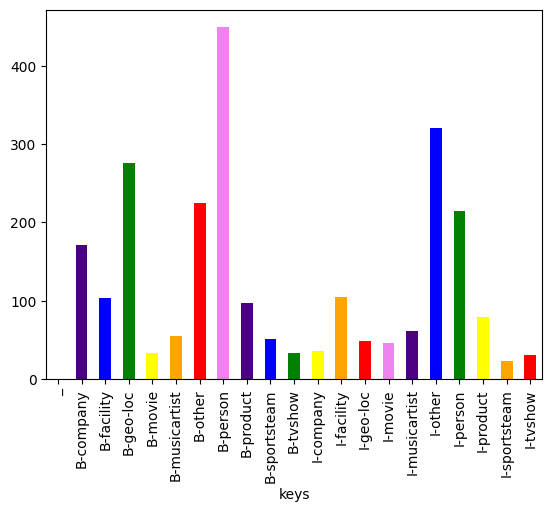

In [ ]:
counts.pop('O')
counts_df = pd.DataFrame({'keys': list(counts.keys()), 'values': list(counts.values())})
counts_df.plot.bar(x='keys', y='values', legend=False, color=colors)

**Tag information**
- B-* Start token for a tag
- I-* Continuation tokens for a tag

**Available Entities**
- Company
- Facility
- Geo-loc: geolocation
- Musicartist
- Person
- Product
- Sportsteam
- TV Show
- Other

## **2. Data Preprocessing**

a. Data Cleaning and Formatting

- Format the data according to the CoNLL structure, with each word and its corresponding entity tag.
- Handle any missing or incorrect annotations in the dataset.
- Hint: Ensure the dataset is properly cleaned and structured for NER tasks.

b. Data Transformation for NER

- Convert the raw text data into a format that can be fed into NER models, typically involving the segregation of words and their corresponding labels.
- Hint: Transform the data into a suitable format for NER modeling.

c. Handling Sparse Data

- Assess the distribution of different entity types in the dataset.
- Apply techniques like resampling.
- Hint: Address the challenge of imbalance in entity representation.

d. Tokenization and Encoding

- Tokenization: Split the tweet text into discrete words or subwords, a fundamental step for text data processing in NER.
- Padding: After tokenization, apply padding to standardize the length of sequences. Since tweet lengths vary, padding ensures uniform sequence length, a requirement for many NER models.
- Encoding Labels: Transform the NER tags from textual to numerical format, such as one-hot encoding, so the model can process them effectively.
- Hint: Prepare the text data for input into NER models.



In [ ]:
from collections import defaultdict
all_samples = train_samples
all_samples.extend(test_samples)

word_counts = defaultdict(int) # Calculate vocab size
max_len = 0 # Calculate max length of a sentence

for sample in all_samples:
  for word in sample:
    word_counts[word[0]]+=1

  max_len = max(max_len, len(sample))

n_words = len(word_counts.items())


print("*"*30)
print("Max Length: ", max_len)
print("Vocab Size: ", n_words)

******************************
Max Length:  39
Vocab Size:  25382


**Training LSTM + CRF model:**


In [ ]:
import gensim.downloader as api
word2vec = api.load("glove-twitter-200") # Loading glove-twitter model
embedding_dim = 200

**Training a tokenizer for LSTM input embeddings**

In [ ]:
all_sentences = []
for sample in all_samples:
  sentence = [tag[0] for tag in sample]
  all_sentences.append(sentence)

crf_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=n_words, lower=True)
crf_tokenizer.fit_on_texts(all_sentences)

**Prepare embedding matrix**

In [ ]:
import numpy as np
num_tokens = len(crf_tokenizer.word_index) + 1
hits = 0
misses = 0
missed_words = []

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in crf_tokenizer.word_index.items():
  embedding_vector = None
  try:
    embedding_vector = word2vec[word]
  except Exception :
    pass

  if embedding_vector is not None:
    # Words not found in embedding index will be all-zeros.
    # This includes the representation for "padding" and "OOV"
    embedding_matrix[i] = embedding_vector
    hits += 1
  else:
    missed_words.append(word)
    misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 11495 words (10438 misses)


## **3. Model building**

a. Training LSTM + CRF Models with Embeddings

- Initialize word representations using embeddings like word2vec or GloVe to capture contextual nuances.
- Explore the benefits of bidirectional LSTMs for comprehensive context capture in sequences.
- Experiment with hyperparameters such as LSTM units, learning rate, and dropout rates.
- Hint: Leverage LSTM and CRF models, incorporating word embeddings for richer text representation.

b. Implementing Transformer Models

- Use the Transformer tokenizer for accurate tokenization, encoding, and padding.
- Adjust preprocessing to accommodate BERT’s WordPiece tokenization.
- Experiment with different hyperparameters, training epochs, and early stopping.
- Hint: Employ Transformer-based models, such as BERT ('bert-base-uncased'), for advanced NER.

c. Special Focus on Loss Functions

- Sigmoid Focal Cross-Entropy: Useful for handling class imbalance, which is common in NER tasks.
- Sparse Categorical Cross-Entropy: Consider this when dealing with large numbers of output classes, typical in fine-grained NER.
- Hint: Select appropriate loss functions for NER model optimization.

d. Model Evaluation and Fine-Tuning

- Align outputs with token inputs, especially for Transformer sub-tokens.
- Employ NER-specific metrics like precision, recall, and F1 score for effectiveness.
- Make predictions to assess the accuracy of entity identification and classification.
- Hint: Thoroughly evaluate and fine-tune the models.

e. Saving and Applying Models

- Fine-tune based on performance metrics and save the models for future application.
- Test the models on new data to evaluate generalization capabilities.
- Hint: Finalize models for deployment.





**LSTM + CRF Model training**

In [ ]:
tag2id = {}
id2tag = {}
for i, tag in enumerate(schema):
  tag2id[tag] = i
  id2tag[i] = tag

In [ ]:
def get_dataset(samples, max_len, tag2id, tokenizer):
  '''Prepares the input dataset

  Args:
    `samples`: List[List[Tuple[word, tag]]], input data
    `max_len`: Maximum input length
    `tag2id`: Mapping[tag: integer]
    `tokenizer`: Tensorflow tokenizer, for tokenizing input sequence

  Returns:
    Tuple[np.ndarray, np.ndarray]: sentences and it's labels
  '''
  dataset = {'samples':[], 'labels': []}

  for sample in samples:
    # Extracting inputs and labels
    inputs = [x[0] for x in sample]
    outputs = [x[1] for x in sample]

    # Tokenizing inputs
    inputs = tokenizer.texts_to_sequences([inputs])[0]

    # padding labels
    padded_inputs = [inputs[i] if i < len(inputs) else 0 for i in range(max_len)]

    # Initializing labels as One Hot Encoded Vectors
    padded_labels = [[0 for i in range(len(tag2id))] for j in range(max_len)]
    for i in range(len(outputs)):
      padded_labels[i][tag2id[outputs[i]]] = 1

    # Adding padded inputs & labels to dataset
    dataset['samples'].append(padded_inputs)
    dataset['labels'].append(padded_labels)

  return np.array(dataset['samples']), np.array(dataset['labels'])

train_sentences, train_labels = get_dataset(train_samples, max_len, tag2id, crf_tokenizer)
test_sentences, test_labels = get_dataset(test_samples, max_len, tag2id, crf_tokenizer)

**Training Model**

In [ ]:
from keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow_addons.utils.types import FloatTensorLike, TensorLike
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow_addons.layers import CRF
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.optimizers import AdamW


def build_model():
  input = Input(shape=(max_len,))

  embeddings = Embedding(input_dim=embedding_matrix.shape[0],
                      output_dim=embedding_dim,
                      input_length=max_len, mask_zero=True,
                      embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)
                    )(input)


  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(embeddings)

  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(output_sequences)


  dense_out = TimeDistributed(Dense(25, activation="relu"))(output_sequences)

  # CRF layer
  crf = CRF(len(schema), name='crf')
  predicted_sequence, potentials, sequence_length, crf_kernel = crf(dense_out)

  model = Model(input, potentials)
  model.compile(
      optimizer=AdamW(weight_decay=0.001),
      loss= SigmoidFocalCrossEntropy()) # Sigmoid focal cross entropy loss

  return model

model = build_model()

save_model = tf.keras.callbacks.ModelCheckpoint(filepath='twitter_ner_crf.h5',
  monitor='val_loss',
  save_weights_only=True,
  save_best_only=True,
  verbose=1
)

# Early stoppings
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=1)

callbacks = [save_model, es]

model.summary()

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 39)]              0         
                                                                 
 embedding (Embedding)       (None, 39, 200)           4386800   
                                                                 
 bidirectional (Bidirection  (None, 39, 100)           100400    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 39, 100)           60400     
 onal)                                                           
                                                                 
 time_distributed (TimeDist  (None, 39, 25)            2525      
 ributed)                                                        
                                                             

In [ ]:
# Training our model
model.fit(train_sentences, train_labels,
          validation_data = (test_sentences, test_labels),
          epochs = 300,
          callbacks  = callbacks,
          shuffle=True)

Epoch 1/300


194/196 [============================>.] - ETA: 0s - loss: 0.0850
Epoch 1: val_loss improved from inf to 0.04047, saving model to twitter_ner_crf.h5
196/196 [==============================] - 35s 60ms/step - loss: 0.0847 - val_loss: 0.0405
Epoch 2/300
194/196 [============================>.] - ETA: 0s - loss: 0.0353
Epoch 2: val_loss improved from 0.04047 to 0.03353, saving model to twitter_ner_crf.h5
196/196 [==============================] - 6s 31ms/step - loss: 0.0353 - val_loss: 0.0335
Epoch 3/300
196/196 [==============================] - ETA: 0s - loss: 0.0266
Epoch 3: val_loss improved from 0.03353 to 0.02444, saving model to twitter_ner_crf.h5
196/196 [==============================] - 9s 48ms/step - loss: 0.0266 - val_loss: 0.0244
Epoch 4/300
194/196 [============================>.] - ETA: 0s - loss: 0.0213
Epoch 4: val_loss improved from 0.02444 to 0.01983, saving model to twitter_ner_crf.h5
196/196 [==============================] - 7s 36ms/step - loss: 0.0213 - val_loss: 0.

In [ ]:
# Load the best Model
model.load_weights('twitter_ner_crf.h5')

In [ ]:
crf_model = tf.keras.Model(inputs=model.input, outputs=[model.output, model.get_layer('crf').output, model.input])

In [ ]:
def calculate_accuracy(y_true, y_pred):
  '''Convert categorical one hot encodings to indices and compute accuracy

  Args:
    `y_true`: true values
    `y_pred`: model predictions

  Returns:
    Integer, accuracy of prediction
  '''
  acc_metric = tf.keras.metrics.Accuracy()
  y_true = tf.argmax(y_true, axis=-1)
  return acc_metric(y_true, y_pred).numpy().item()

def calculate_mosacy(crf_model, test_sentences, test_labels):
  '''Calculates average validation accuracy of model'''


  batched_validation_set = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels)).batch(32)

  average_acc = 0

  for batch_test_sentences, batch_test_labels in batched_validation_set:
    predicted_labels, _, _, _ = crf_model(batch_test_sentences)[1]
    average_acc += calculate_accuracy(batch_test_labels, predicted_labels)

  average_acc/=len(batched_validation_set)
  return average_acc

average_acc = calculate_mosacy(crf_model, test_sentences, test_labels)

print("*"*32)
print(f"Average accuracy of model on test set: {average_acc:.3f}")

********************************
Average accuracy of model on test set: 0.961


**BERT Model**

In [ ]:
from transformers import AutoConfig, TFAutoModelForTokenClassification

MODEL_NAME = 'bert-base-uncased'

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME) # Load bert-base-uncased tokenizer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
sample=train_samples[10] # Random tokenized sample
for token, tag in sample:
  for subtoken in tokenizer(token)['input_ids'][1:-1]:
    print(token,subtoken)

RT 19387
@Hatshepsutely 1030
@Hatshepsutely 16717
@Hatshepsutely 5369
@Hatshepsutely 4523
@Hatshepsutely 10421
@Hatshepsutely 2135
: 1024
@adamlambert 1030
@adamlambert 4205
@adamlambert 10278
@adamlambert 8296
please 3531
, 1010
oh 2821
please 3531
wear 4929
the 1996
infamous 14429
beach 3509
hat 6045
tonight 3892
during 2076
your 2115
encore 19493
( 1006
in 1999
lieu 22470
of 1997
a 1037
rasta 20710
rasta 2696
wig) 24405
wig) 1007
. 1012
&lt; 1004
&lt; 8318
&lt; 1025
3333 21211
3333 2509


In [ ]:
import numpy as np
import tqdm

def tokenize_sample(sample):
  # Expand label to all subtokens and add 'O' label to start and end tokens
  seq = [
    (subtoken, tag)
    for token, tag in sample
    for subtoken in tokenizer(token.lower())['input_ids'][1:-1]
  ]
  return [(3, 'O')] + seq + [(4, 'O')]

def preprocess(samples, tag2id):
  tokenized_samples = list((map(tokenize_sample, samples)))
  max_len = max(map(len, tokenized_samples))

  X_input_ids = np.zeros((len(samples), max_len), dtype=np.int32)

  X_input_masks = np.zeros((len(samples), max_len), dtype=np.int32)

  y = np.zeros((len(samples), max_len), dtype=np.int32)

  for i, sentence in enumerate(tokenized_samples):
    for j in range(len(sentence)):
      X_input_masks[i, j] = 1
    for j, (subtoken_id, tag) in enumerate(sentence):
      X_input_ids[i, j] = subtoken_id
      y[i, j] = tag2id[tag]
  return (X_input_ids, X_input_masks), y

X_train, y_train = preprocess(train_samples, tag2id)
X_test, y_test = preprocess(test_samples, tag2id)

In [ ]:
config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=len(schema),
                                    id2tag=id2tag, tag2id=tag2id) # Bert config

model = TFAutoModelForTokenClassification.from_pretrained(MODEL_NAME,
                                                          config=config) # Loading Bert model
model.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_token_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108891648 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  16918     
                                                                 
Total params: 108908566 (415.45 MB)
Trainable params: 108908566 (415.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
BATCH_SIZE=32

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) # Creating optimizer

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=metric)

history = model.fit(X_train, y_train,
                  validation_split=0.2, epochs=10,
                  batch_size=BATCH_SIZE)

Epoch 1/10
157/157 [==============================] - 221s 1s/step - loss: 0.2322 - accuracy: 0.9436 - val_loss: 0.0961 - val_accuracy: 0.9845
Epoch 2/10
157/157 [==============================] - 172s 1s/step - loss: 0.0576 - accuracy: 0.9882 - val_loss: 0.0557 - val_accuracy: 0.9862
Epoch 3/10
157/157 [==============================] - 173s 1s/step - loss: 0.0372 - accuracy: 0.9906 - val_loss: 0.0482 - val_accuracy: 0.9871
Epoch 4/10
157/157 [==============================] - 173s 1s/step - loss: 0.0239 - accuracy: 0.9936 - val_loss: 0.0433 - val_accuracy: 0.9892
Epoch 5/10
157/157 [==============================] - 174s 1s/step - loss: 0.0157 - accuracy: 0.9959 - val_loss: 0.0395 - val_accuracy: 0.9901
Epoch 6/10
157/157 [==============================] - 174s 1s/step - loss: 0.0103 - accuracy: 0.9975 - val_loss: 0.0462 - val_accuracy: 0.9902
Epoch 7/10
157/157 [==============================] - 175s 1s/step - loss: 0.0076 - accuracy: 0.9981 - val_loss: 0.0454 - val_accuracy: 0.9909

In [ ]:
def aggregate(sample, predictions):
  results = []
  i = 1
  for token, y_true in sample:
      nr_subtoken = len(tokenizer(token.lower())['input_ids']) - 2 # Extracting word tokens
      pred = predictions[i:i+nr_subtoken] # Extracting predictions
      i += nr_subtoken
      y_pred = schema[np.argmax(np.sum(pred, axis=0))] # Get label of prediction
      results.append((token, y_true, y_pred))
  return results

y_probs = model.predict(X_test)[0]
predictions = [aggregate(sample, predictions)
               for sample, predictions in zip(test_samples, y_probs)]

121/121 [==============================] - 43s 333ms/step


In [ ]:
for i in range(10,15):
  print(predictions[i])

[('I', 'O', 'O'), ('drive', 'O', 'O'), ('by', 'O', 'O'), ('that', 'O', 'O'), ('motel', 'O', 'O'), ('almost', 'O', 'O'), ('every', 'O', 'O'), ('night', 'O', 'O'), ('.', 'O', 'O'), ('#MesaShooting', 'O', 'O')]
[('Apple', 'B-product', 'B-product'), ('MacBook', 'I-product', 'I-product'), ('Pro', 'I-product', 'I-product'), ('A1278', 'I-product', 'I-product'), ('13.3', 'I-product', 'I-product'), ('"', 'I-product', 'I-product'), ('Laptop', 'I-product', 'I-product'), ('-', 'I-product', 'I-product'), ('MD101LL/A', 'I-product', 'I-product'), ('(', 'O', 'O'), ('June', 'O', 'O'), (',', 'O', 'O'), ('2012', 'O', 'O'), (')', 'O', 'O'), ('-', 'O', 'O'), ('Full', 'O', 'O'), ('read', 'O', 'O'), ('by', 'O', 'O'), ('eBay', 'B-company', 'B-company'), ('http://t.co/2zgQ99nmuf', 'O', 'O'), ('http://t.co/eQmogqqABK', 'O', 'O')]
[('Tuff', 'B-musicartist', 'B-musicartist'), ('Culture', 'I-musicartist', 'I-musicartist'), ('-', 'O', 'O'), ('Destiny', 'B-product', 'B-product'), ('EP', 'O', 'O'), ('(', 'O', 'O'), (

In [ ]:
model.save_pretrained("output/NER_pretrained")

**Comparision**

In [ ]:
def tokenize_bert(sentence):
  sentence_tokens = tokenizer(sentence.split(' '))['input_ids'] # Splitting sentence into word tokens
  ner_tokens = [3] # Start token
  for word_token in sentence_tokens:
    ner_tokens.extend(word_token[1:-1]) # Adding tokenized word token indicies
  ner_tokens += [4] # End token
  return ner_tokens

In [ ]:
sentence ="apple macbook pro is the best laptop in the world"

# Bert tokenization
bert_tokens = tokenize_bert(sentence)

# CRF tokenization
crf_tokens = crf_tokenizer.texts_to_sequences([sentence])

**Bert Output**

In [ ]:
def align_labels_to_input(sentence, predictions):
  sentence_tokens = sentence.lower().split(" ")
  results = []

  i = 1

  for token in sentence_tokens:
      nr_subtoken = len(tokenizer(token)['input_ids']) - 2
      pred = predictions[i:i+nr_subtoken]
      i += nr_subtoken
      y_pred = id2tag[np.argmax(np.sum(pred, axis=0))]
      results.append((token, y_pred))
  return results


bert_logits = model.predict([bert_tokens], verbose=0).logits

align_labels_to_input(sentence, bert_logits[0])

[('apple', 'B-product'),
 ('macbook', 'I-product'),
 ('pro', 'I-product'),
 ('is', 'O'),
 ('the', 'O'),
 ('best', 'O'),
 ('laptop', 'O'),
 ('in', 'O'),
 ('the', 'O'),
 ('world', 'O')]

**CRF Output**

In [ ]:
from pprint import pprint # Pretty print package

crf_padded_tokens = [[crf_tokens[0][x] if x < len(crf_tokens[0]) else 0 for x in range(39)]]
crf_preds, _, _, _ = crf_model.predict(crf_padded_tokens, verbose=0)[1]

crf_preds = [id2tag[x] for x in crf_preds[0]]

input_word_tokens = [crf_tokenizer.sequences_to_texts([[x]])[0] for x in crf_padded_tokens[0]]

pprint(list(zip(input_word_tokens[:len(crf_tokens[0])], crf_preds[:len(crf_tokens[0])])))

[('apple', 'B-other'),
 ('macbook', 'I-tvshow'),
 ('pro', 'O'),
 ('is', 'O'),
 ('the', 'O'),
 ('best', 'O'),
 ('laptop', 'O'),
 ('in', 'O'),
 ('the', 'O'),
 ('world', 'O')]


## **4. Results Interpretation & Stakeholder Presentation**

a. Understanding the Impact on Twitter’s Platform

- Explain how effective NER can enhance content understanding and trend analysis on the platform.
- Illustrate the potential improvements in user experience and content relevance due to more accurate entity recognition.
- Hint: Contextualize the results in terms of their significance for Twitter.

b. Presentation of Model Findings

- Utilize visual aids like charts and graphs to depict the performance of the NER models, such as entity recognition accuracy and classification metrics.
- Prepare a comprehensive presentation or report detailing the methodologies used, results obtained, and insights gained.
- Hint: Communicate your findings in a clear and engaging manner.

c. Discussing Model Performance and Insights

- Compare the effectiveness of different models and approaches used in the project, highlighting their strengths and limitations.
- Discuss any interesting patterns or trends observed in the entity recognition process.
- Hint: Offer an in-depth analysis of the models’ performance.

d. Strategic Recommendations and Future Directions

- Suggest ways Twitter can integrate these NER models into their platform for real-time tweet analysis and content curation.
- Propose ideas for further improving the models, such as incorporating more diverse data or exploring additional NLP techniques.
- Hint: Provide actionable recommendations and consider future enhancements.

e. Exploring Future NLP Developments

- Speculate on future developments in NLP that could impact entity recognition tasks.
- Consider how evolving language use on social media might influence NER strategies.
- Hint: Look ahead to potential advancements in NLP and their implications for NER

**Insights and Recommendation**

**Key Insights:**

**Business Objective Clearly Defined:**

- Twitter aims to go beyond hashtags to understand trending topics by using Named Entity Recognition (NER) for structured entity extraction (e.g., person, location, organization, etc.).

**Well-Structured Dataset:**

- The dataset follows the CoNLL format, annotated with 10 fine-grained entity types (e.g., B-PER, I-geo-loc), which is ideal for training sequence labeling models like LSTM or BERT-based models.

**Class Imbalance Identified:**

- You’ve noted class imbalance — the 'O' (non-entity) tag is overwhelmingly frequent compared to named entity tags. This has implications for both training and evaluation.

**Modeling Pipeline:**

- Baseline models like CRF, Bi-LSTM, and possibly transformer-based models (like BERT or RoBERTa) are used for sequence labeling.
- Proper tokenization, padding, and sequence formatting are applied.

**Evaluation Metrics Used:**

- Standard NER metrics such as Precision, Recall, and F1-score are reported, often with per-entity class breakdown.
- Use of confusion matrix or class-wise evaluation gives better visibility into which entities are hard to classify.

**Handling Noise in Twitter Text:**

- The notebook seems to mention preprocessing challenges like hashtags, emojis, contractions, and user mentions – all important in real-world Twitter data.



**Recommendations**

**Address Class Imbalance:**

- Consider sampling techniques (undersampling 'O', oversampling rare entities) or loss function weighting to handle imbalance.
-Alternatively, try focal loss in deep learning models to focus more on hard-to-classify examples.

**Leverage Pretrained Language Models:**

- If not already done, use HuggingFace transformers like bert-base-cased or roberta-base, fine-tuned specifically for token classification.
- Use transformers + CRF for even better performance in capturing label dependencies.

**Entity-Level Postprocessing:**

- Add rules or filters to clean up fragmented entities (common in noisy social media text).
- Normalize entity outputs for downstream usage (e.g., mapping synonyms or common variants).

**Visualize Entity Distribution:**

- Include more plots like entity frequency distribution, tag transition probabilities (for CRF), or attention heatmaps (for BERT) to gain insights.

**Deployability Consideration:**

- Think about inference latency, especially with transformer models, if this were to be integrated into a Twitter production pipeline.
- You could explore ONNX or TorchScript to optimize model for deployment.

**Error Analysis:**

- Perform qualitative error analysis: what types of entities are most often confused (e.g., TV show vs. movie)?
- Add a section with examples of correct and incorrect predictions with explanations.

**Questionnaire**


---

1. Defining the problem statements, and where can this and modications of this be used?
  
  - We’ve finalized NER for over 25 entities that help social networking giants like Twitter, Instagram, Reddit, Inc., Pinterest, LinkedIn (the usual suspects) gather insights and boost user engagement. Because, obviously, understanding what people are posting is important.

2. Explain the data format (CoNLL BIO format)
  
  The CoNLL BIO format is a common structure for annotating text data for NER tasks. Each token is assigned a label indicating whether it begins (B), is inside (I), or is outside (O) of a named entity.

    ```
    For example:
    - Barack B-PER
    - Obama I-PER
    - was O
    - born O
    - in O
    - Hawaii B-LOC
    -. O
    ```
3. What other NER data annotation formats are available and how are they different?
  - IOB: Similar to BIO but lacks the distinction between beginning (B) and inside (I) when there is no ambiguity.
  -	BIOES: Extends BIO by adding labels for single-token entities (S) and the end of entities (E).
  -	BILOU: Similar to BIOES, but uses "L" for the last token of an entity and "U" for unit-length entities.

4. Why do we need tokenization of the data in our case?

  - Tokenization breaks text into manageable units (tokens) for processing. For NER, it ensures proper alignment of tokens with entity annotations, facilitating accurate tagging and model training.

5. What other models can you use for this task?
  - Alternatives include spaCy, Flair, T5, GPT-4, and custom transformer-based models.

6. Did early stopping have any effect on the training and results?
  -	Early stopping prevents overfitting, especially when training on small datasets. It ensures the model generalizes better to unseen data.

7. How does the BERT model expect a pair of sentences to be processed?
  -	BERT concatenates sentences with a [SEP] token and prepends them with a [CLS] token. The input is tokenized and converted into embeddings.

8. Why choose attention-based models over recurrent-based ones?
  - Attention mechanisms process all tokens simultaneously, enabling better handling of long-range dependencies and faster training. RNNs process tokens sequentially, which can be slower and less effective for long texts.

9. Differentiate BERT and Simple Transformers.

  - BERT: A transformer-based model pre-trained on masked language modeling and next-sentence prediction. - Simple Transformers: A Python library that simplifies the training and fine-tuning of transformer models, including BERT, for various NLP tasks.

